# Campo de humedad relativa media diaria

Ejemplo para el cálculo de la humedad relativa media en una subregión. <br />
*Example of the mean relative humidity field over a user-defined subregion.*

In [3]:
# Importamos las librerías necesarias  (en caso de ser necesario, instalar utilizando el comando pip install)
# We import the necessary libraries    (if needed, install by using the command pip install)
import xarray as xr
import h5netcdf
import datetime
import s3fs
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import regionmask

Definimos la fecha y hora de inicialización del pronóstico: <br />
*We define the forecast initialization date:* 

In [4]:
init_year = 2022
init_month = 4
init_day = 1
init_hour = 0
INIT_DATE = datetime.datetime(init_year, init_month, init_day, init_hour)

Definimos el periodo de tiempo sobre el cual se calcula la humedad relativa media: <br />
*We define the averaging period for relative humidity:*

In [5]:
start_lead_time = 0
end_lead_time = 47

Definimos la región a graficar: <br />
*We define the region of interest (using lat and lon):*

In [6]:
lat_min = -60
lat_max = -30
lon_min = -80
lon_max = -60

Leemos los pronósticos: <br />
*We read the forecasts:*

In [ ]:
# Opción 1: Para acceder al archivo online
# Option 1: To access files online
#fs = s3fs.S3FileSystem(anon=True)

#files = [f'smn-ar-wrf/DATA/WRF/DET/{FCST_DATE:%Y/%m/%d/%H}/WRFDETAR_01H_{FCST_DATE:%Y%m%d_%H}_{fhr:03d}.nc' for fhr in range(start_fhr, final_fhr)]
#ds_list = []
#for s3_file in files:
#    print(s3_file)
#    if fs.exists(s3_file):
#        f = fs.open(s3_file)
#        ds_tmp = xr.open_dataset(f, decode_coords = 'all', engine = 'h5netcdf')
#        ds_list.append(ds_tmp)
#    else:
#        print('The file {} does not exist'.format(s3_file))

# Opción 2: Para abrir los archivos ya descargados
# Option 2: To open the already downloaded files
files = ['WRFDETAR_01H_{:%Y%m%d_%H}_{:03d}.nc'.format(INIT_DATE,lead_time) for lead_time in range(start_lead_time, end_lead_time)]
print(files)
ds_list = []
for filename in files:
    print(filename)
    ds_tmp = xr.open_dataset(filename, decode_coords = 'all', engine = 'h5netcdf')
    ds_list.append(ds_tmp)

# Combinamos los archivos en un unico dataset
# We combine all the files in one dataset
ds = xr.combine_by_coords(ds_list, combine_attrs = 'drop_conflicts')

Seleccionamos los datos pertenecientes a la región y se calcula la humedad relativa media diaria: <br />
*We select the data of the chose subdomain and we compute the mean value:*




In [11]:
corners = [[lon_min, lat_min], [lon_min, lat_max], [lon_max, lat_max], [lon_max, lat_min]]

# Armamos la máscara de la región
# We build the mask defining the region  
region = regionmask.Regions([corners])
mask = region.mask(ds['lon'], ds['lat'])

# Seleccionamos la variable HR2 y se calcula el valor medio diario
# We select the variable HR2 and compute the daily mean at each gridpoint
var = 'HR2'
HR = ds[[var]]
HR_mean = HR.mean(dim = 'time')

# Aplicamos la máscara eliminando los valores por fuera de ésta
# We eliminate the values outside the mask 
HR_region = HR_mean.where(mask == 0, drop = True)

Generamos la figura: <br />
*We generate the plot:*

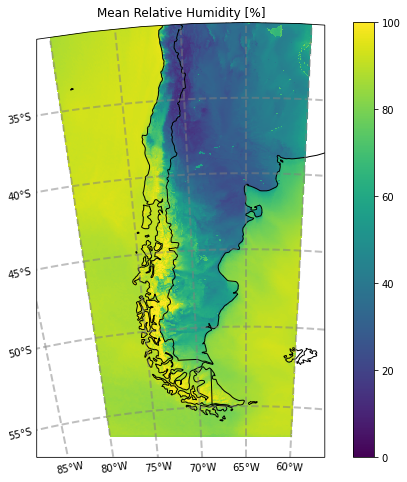

In [13]:
# Seleccionamos la proyección de los datos
# We chose a map projection
proyection = ccrs.LambertConformal(central_longitude = ds.CEN_LON, 
                                   central_latitude = ds.CEN_LAT, 
                                   standard_parallels = (ds.TRUELAT1, 
                                                         ds.TRUELAT2))

fig = plt.figure(figsize = (10, 8)) 
ax = plt.axes(projection = proyection)
cbar = ax.pcolormesh(HR_region['lon'], HR_region['lat'], HR_region['HR2'], transform = ccrs.PlateCarree(), vmin = 0, vmax = 100)
ax.add_feature(cf.COASTLINE) # add coastlines
ax.add_feature(cf.BORDERS)   # add country borders
ax.set_title(f'Mean Relative Humidity [%]')

gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True, x_inline = False,
                  linewidth = 2, color = 'gray', alpha = 0.5, linestyle = '--')
gl.top_labels = False
gl.right_labels = False
plt.colorbar(cbar)